In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.patheffects
import matplotlib.pyplot as plt
import multiprocessing
import math
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib import transforms
from multiprocessing import Pool
from statsmodels.sandbox.stats import multicomp

sys.path.append("utils")
import pyximport; pyximport.install()
import cython_fnx
from utils import *
from plotting_utils import *

## 1. define & collect arguments

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument("-s", "--seed", type=int, required=False, default=12345, 
#                     help="numpy.random seed to use (for reproducibility)")
# parser.add_argument("-p", "--pwm_file", type=str, required=True, 
#                     help="path to pwm file in MEME format")
# parser.add_argument("-d", "--deletion_info_file", type=str, required=True, 
#                     help="path to file containing list of deletion files to analyze (full paths)")
# parser.add_argument("-l", "--seq_len", type=int, required=True, 
#                     help="length of sequences used in deletion MPRA")
# parser.add_argument("-f", "--offset", type=int, required=False, default=1,
#                     help="# bp that the start number in deletion files is offset from 0")
# parser.add_argument("-b", "--buffer", type=int, required=False, default=0,
#                     help="# bp that on either flank that are not deleted from the reference sequence")
# parser.add_argument("-w", "--bandwidth", type=int, required=False, default=5,
#                     help="bandwidth to use in moving average smoother (NOTE: should be odd)")
# parser.add_argument("-p", "--peak_cutoff", type=float, required=False, default=0.5,
#                     help="cutoff to use when calling peaks")
# parser.add_argument("-t", "--score_type", type=str, required=True, 
#                     help="either 'loss' or 'gain'")
# parser.add_argument("-n", "--n_shuffles", type=int, required=False, default=10000,
#                     help="# times to shuffle peak data to get null distribution")
# parser.add_argument("-e", "--tfs_expressed_file", type=str, required=False, default=None, 
#                     help="path to file containing list of TFs expressed in cell line of interest")
# parser.add_argument("-c", "--cores", type=int, required=True,
#                     help="# cores to use when computing")
# parser.add_argument("-o", "--out_dir", type=str, required=True, 
#                     help="directory where results will be stored")

In [3]:
# args = parser.parse_args()
# seed = args.seed
# pwm_file = args.pwm_file
# deletion_info_file = args.deletion_info_file
# seq_len = args.seq_len
# offset = args.offset
# buffer = args.buffer
# bandwidth = args.bandwidth
# peak_cutoff = args.peak_cutoff
# score_type = args.score_type
# n_shuffles = args.n_shuffles
# tfs_expressed_file = args.tfs_expressed_file
# cores = args.cores
# out_dir = args.out_dir

In [4]:
seed = 12345
pwm_file = "inputs/0__pwm/pfm_vertebrates_meme_motifNameChanged.txt"
deletion_info_file = "inputs/1__dels/deletion_files.txt"
seq_len = 94
offset = 1
buffer = 10
bandwidth = 5
peak_cutoff = 0.5
score_type = "loss"
n_shuffles = 1000
tfs_expressed_file = None
cores = 4
out_dir = "results/test"

In [5]:
### argument assertions ###

# pwm file exists
assert os.path.exists(pwm_file), "--pwm_file path does not exist"

# deletion file exists
assert os.path.exists(deletion_info_file), "--deletion_info_file path does not exist"

# bandwidth is odd
assert bandwidth % 2 == 1, "--bandwidth should be an odd number"

# score is either loss or gain
assert score_type in ["loss", "gain"], "--score_type should be either 'loss' or 'gain'"

# tf file exists if given
if tfs_expressed_file != None:
    assert os.path.exists(tfs_expressed_file), "--tfs_expressed_file path does not exist"

In [6]:
### set plotting defaults ###
sns.set(**PRESET)
fontsize = FONTSIZE

## 2. import data & make out dir if needed

In [7]:
# set seed for reproducibility!
np.random.seed(seed)

In [8]:
# read in pwm file
motifs, motif_lens, motif_len_map = parse_pfm(pwm_file, False)

In [9]:
# find max motif length
max_motif_len = np.max(list(motif_lens))

In [10]:
# read in file with paths to all of the deletion data
deletion_info = pd.read_table(deletion_info_file, sep="\t", header=None)
deletion_info.columns = ["path", "name"]
deletion_info["path"] = deletion_info["path"].map(str.strip)
deletion_info["name"] = deletion_info["name"].map(str.strip)
deletion_info = zip(list(deletion_info["path"]), list(deletion_info["name"]))

In [11]:
# read in all of the deletion data and make sure it has the columns we need
data = {}
for path, name in deletion_info:
    
    assert os.path.exists(path), "path to deletion data %s does not exist" % path
    df = pd.read_table(path, sep="\t")
    
    assert "delpos" in df.columns, "deletion file %s does not have 'delpos' as a column name" % path
    assert "seq" in df.columns, "deletion file %s does not have 'seq' as a column name" % path
    assert "mean.log2FC" in df.columns, "deletion file %s does not have 'mean.log2FC' as a column name" % path
    assert "sd" in df.columns, "deletion file %s does not have 'sd' as a column name" % path
    assert "se" in df.columns, "deletion file %s does not have 'se' as a column name" % path
    
    data[name] = df

In [12]:
# read in the tfs expressed file, if it exists
if tfs_expressed_file != None:
    tfs_expressed = pd.read_table(tfs_expressed_file, sep="\t", header=None)
    tfs_expressed.columns = ["tf"]
    tfs_expressed = list(tfs_expressed["tf"])
else:
    tfs_expressed = None

In [13]:
# make subdir for results files
res_dir = "%s/files" % out_dir
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
    
# make subdir for figures
figs_dir = "%s/figs" % out_dir
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

## 2. create loss or gain score
loss = looking for transcriptional activators; gain = looking for transcriptional repressors

In [14]:
for seq in data.keys():
    df = data[seq]

    if score_type == "loss":
        df["loss_score_raw"] = df.apply(loss_score, col="mean.log2FC", axis=1)
        
        # scale scores (only if there are scores > 2, otherwise don't)
        scores = list(df["loss_score_raw"])
        scores.extend([0, 2])
        scaled_scores = scale_range(scores, 0, 2)
        del scaled_scores[-2:]
        df["loss_score_raw_scaled"] = scaled_scores
        
    elif score_type == "gain":
        df["gain_score_raw"] = df.apply(gain_score, col="mean.log2FC", axis=1)
        
        # scale scores (only if there are scores > 2, otherwise don't)
        scores = list(df["gain_score_raw"])
        scores.extend([0, 2])
        scaled_scores = scale_range(scores, 0, 2)
        del scaled_scores[-2:]
        df["gain_score_raw_scaled"] = scaled_scores

In [15]:
data["ZBTB37__p1__tile1__plus"].head()

,delpos,mean.log2FC,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end,scaled_score,sd,loss_score_raw,loss_score_raw_scaled
0,11,-0.183961,0.046054,C,1.0,not sig,-0.117565,0.909995,sig active,chr1,173837344.0,173837458.0,-0.021627,0.178367,0.183961,0.183961
1,12,0.020221,0.039380,G,1.0,not sig,-0.117565,0.909995,sig active,chr1,173837344.0,173837458.0,0.002377,0.152518,0.000000,0.000000
2,13,-0.049337,0.034050,A,1.0,not sig,-0.117565,0.909995,sig active,chr1,173837344.0,173837458.0,-0.005800,0.131875,0.049337,0.049337
3,14,-0.249098,0.085598,C,1.0,not sig,-0.117565,0.909995,sig active,chr1,173837344.0,173837458.0,-0.029285,0.331520,0.249098,0.249098
4,15,0.166607,0.073590,T,1.0,not sig,-0.117565,0.909995,sig active,chr1,173837344.0,173837458.0,0.019587,0.285014,0.000000,0.000000


## 3. find peaks in the sequences

In [16]:
%matplotlib inline

In [17]:
# make subdir for peak figures
peak_figs_dir = "%s/0__peaks" % figs_dir
if not os.path.exists(peak_figs_dir):
    os.makedirs(peak_figs_dir)

ZBTB37__p1__tile1__plus


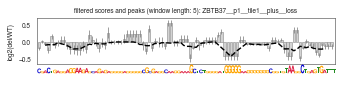

ZFAS1__p1__tile1__plus


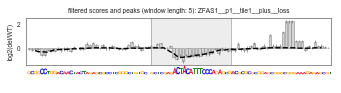

ZBTB37__p1__tile2__plus


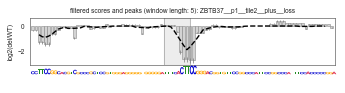

ZFAS1__p1__tile2__plus


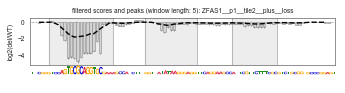

In [18]:
score_col = "%s_score_raw_scaled" % (score_type)
data_peaks = {}
peak_dfs = {}

for seq in data.keys():
    print(seq)
    seq_name = "%s__%s" % (seq, score_type)

    # extract bases & scores from df
    df = data[seq]
    bases = list(df["seq"])
    scaled_scores = list(df[score_col])
    yerrs = list(df["se"])
    raw_scores = list(df["mean.log2FC"])
    
    # apply moving average to scores
    scores_filt = moving_average(bandwidth, scaled_scores)
    df["filtered_score"] = scores_filt
    
    # find peaks
    widths, peak_info, df = find_peaks(peak_cutoff, seq_len, df, 
                                       scores_filt, scaled_scores, bases, buffer, 
                                       max_motif_len)
    data_peaks[seq] = peak_info
    peak_dfs[seq] = df

    # plot peaks
    plot_peaks((4.9, 1.4), 6, score_type, seq_len, seq_name, bandwidth, widths, raw_scores, yerrs, scores_filt, 
               scaled_scores, bases, peak_figs_dir)

## 4. find motifs in the peaks

In [19]:
results_dict = get_all_results(cores, data_peaks, motifs, n_shuffles, seed, parallel=True)

using multiprocessing
seq name: ZBTB37__p1__tile1__plus | n peaks: 0
seq name: ZFAS1__p1__tile1__plus | n peaks: 1
seq name: ZBTB37__p1__tile2__plus | n peaks: 1
seq name: ZFAS1__p1__tile2__plus | n peaks: 3

getting results...
ZBTB37__p1__tile1__plus (Thu May 31 14:29:32 2018)
ZFAS1__p1__tile1__plus (Thu May 31 14:29:32 2018)
ZBTB37__p1__tile2__plus (Thu May 31 14:30:49 2018)
ZFAS1__p1__tile2__plus (Thu May 31 14:30:49 2018)
time elapsed: 126.1348729133606


## 5. correct results for mult. hyp. & plot

In [20]:
# make subdir for results figures
res_figs_dir = "%s/1__results" % figs_dir
if not os.path.exists(res_figs_dir):
    os.makedirs(res_figs_dir)

ZFAS1__p1__tile1__plus__peak1
ALL MOTIFS: found 8 motifs at 0.15 FDR


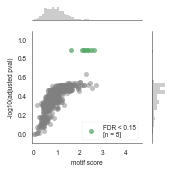

ZBTB37__p1__tile2__plus__peak1
ALL MOTIFS: found 25 motifs at 0.05 FDR


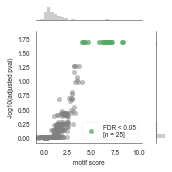

ZFAS1__p1__tile2__plus__peak1
ALL MOTIFS: found 21 motifs at 0.1 FDR


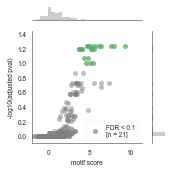

ZFAS1__p1__tile2__plus__peak2
ALL MOTIFS: found 22 motifs at 0.1 FDR


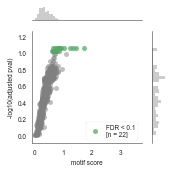

ZFAS1__p1__tile2__plus__peak3
ALL MOTIFS: found 0 motifs at 0.15 FDR


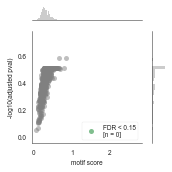

In [22]:
# check motifs at 3 FDRs (since every peak is different)
alphas = [0.05, 0.1, 0.15]

for seq in results_dict:
    seq_results = results_dict[seq]
    n_peaks = len(seq_results)
    for p in range(n_peaks):
        name = "%s__peak%s" % (seq, p+1)
        print(name)
        peak_results = seq_results[p]
        deduped_dict = {}

        # for every motif, choose the max of either sense or antisense pwm
        for motif in peak_results:
            sense_score = peak_results[motif][0][2]
            antisense_score = peak_results[motif][1][2]
            if sense_score >= antisense_score:
                max_row = peak_results[motif][0]
                max_row.extend(["sense"])
            else:
                max_row = peak_results[motif][1]
                max_row.extend(["antisense"])
            max_row_fixed = list(max_row[0:8])
            deduped_dict[motif] = max_row_fixed
            
        df = pd.DataFrame.from_dict(deduped_dict, orient="index").reset_index()
        df.columns = ["motif", "start", "end", "score", "pval", "tile_chr", "tile_start", 
                      "tile_end", "strand"]
        
        # correct p values for multiple testing
        padj = multicomp.multipletests(list(df["pval"]), method="fdr_bh")[1]
        df["padj"] = padj
        df["neg_log_pval"] = -np.log10(df["padj"])
        
        for alpha in alphas:
            sig_df = df[df["padj"] < alpha]
            if len(sig_df) > 0:
                break
        print("ALL MOTIFS: found %s motifs at %s FDR" % (len(sig_df), alpha))
        df["fdr_cutoff"] = alpha
        df = df.sort_values(by="score", ascending=False)
        df.to_csv("%s/%s.%s__results.txt" % (res_dir, name, score_type), sep="\t", index=False)

        
        # if a list of TFs expressed was provided, filter to those only & adjust those only
        if tfs_expressed != None:
            df_sub = df[df["motif"].isin(tfs_on)]
        
            padj = multicomp.multipletests(list(df_sub["pval"]), method="fdr_bh")[1]
            df_sub["padj"] = padj
            df_sub["neg_log_pval"] = -np.log10(df_sub["padj"])
        
        
            for alpha in alphas:
                sig_df_sub = df_sub[df_sub["padj"] < alpha]
                if len(sig_df_sub) > 0:
                    break
            print("ONLY TFS EXPRESSED: found %s motifs at %s FDR" % (len(sig_df), alpha))
            df_sub["fdr_cutoff"] = alpha
            df_sub = df_sub.sort_values(by="score", ascending=False)
            df_sub.to_csv("%s/%s.%s__results.expr_filt.txt" % (res_dir, name, score_type), sep="\t", 
                          index=False)
        
        # plot the all results only
        plot_motif_results(df, 2.5, name, alpha, res_figs_dir)
        